# Capstone Webscrapping using BeautifulSoup

This notebook contains guidances & tasks on the data processing for the application

## Background

This project is about scrap popular movie released in year 2021 from website imdb.com. Imdb, stands for internet movie database, is a site that give information about movie related in detail, like what is the movie genre, when movie released, who is director, stars played in a movie, some trivia and most importantly, user review and voting that give result into imdb rating.

Most of people who want to watch movie in cinema, rent a DVD, or digital streaming service, they need to find review or watch trailer first before commit spent times and money. This is that will be provided by website imbd. Other than imbd, there are many similar website like rottentomatoes and metacritics.

We will scrap several points: title, imdb rating, vote count and metascore. From these points, we want to ascertain if rating from imdb is representing a sample of populace distributely enough or bias. 

## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [2]:
import requests

url_get = requests.get('https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31&count=250')

To visualize what exactly you get from the `request.get`, we can use .content so ee what we exactly get, in here i slice it so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [3]:
url_get.content[1:500]

b'\n<!DOCTYPE html>\n<html\n    xmlns:og="http://ogp.me/ns#"\n    xmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n         \n\n        <meta charset="utf-8">\n\n\n\n\n        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:\'java\'};</script>\n\n<script>\n    if (typeof uet == \'function\') {\n      uet("bb", "LoadTitle", {wb: 1});\n    }\n</script>\n  <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>\n      '

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on your web browser. But we as human still confused what and where we can use that piece of code, so here where we use the beautifulsoup. Beautiful soup class will result a beautifulsoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects. 

Let's make Beautiful soup object and feel free to explore the object here.

In [4]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")

## Finding the right key to scrap the data & Extracting the right information

Find the key and put the key into the `.find()` Put all the exploring the right key at this cell. (please change this markdown with your explanation)

In [5]:
table = soup.find('div', attrs={'class':'lister-list'})
print(table.prettify()[1:500])

div class="lister-list">
 <div class="lister-item mode-advanced">
  <div class="lister-top-right">
   <div class="ribbonize" data-caller="filmosearch" data-tconst="tt8179402">
   </div>
  </div>
  <div class="lister-item-image float-left">
   <a href="/title/tt8179402/">
    <img alt="Fate: The Winx Saga" class="loadlate" data-tconst="tt8179402" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BMzEyYzBhODYtZjZlOC00MTM4LWIxMjQtMTRhZjA5ODM4ZWI2XkEyXkFqcGdeQXVyODQwODA1MjY@._V1_UY98_CR5


Finding row length.

In [6]:
#### judul , imdb rating , votes, dan metascore
judul_all = table.find_all('h3', attrs={'class':'lister-item-header'})
row_length = len(judul_all)

metascore_bar = table.find_all('div', attrs={'class':'ratings-bar'})

In [7]:
# debugging / testing code

# judul_all[4].text.strip().split('\n')[1]

# imdb_rating = metascore_bar[0].find('meta', attrs={'itemprop':'ratingValue'})['content']
# votes = metascore_bar[0].find('meta', attrs={'itemprop':'ratingCount'})['content']

# find_metascore = metascore_bar[3].find_all('span', attrs={'class':'metascore favorable'})
# metascore = find_metascore[0].text.strip() if (find_metascore) else 'missing' 

# genre_all = table.find_all('div', attrs={'class':'lister-item-content'})
# genre = genre_all[2].find('span', attrs={'class':'genre'}).text.strip()

# get release date
# table_rd[28].find_all('td')[0].find('a')['href'].split('region=')[1]
# table_rd[28].find_all('td')[1].text.split(' ')

In [8]:
#  jalan lain menuju roma
# ratings_bar =  table.find('div', attrs={'class':'ratings-bar'})
# imdb_rating = ratings_bar.find_all('div', attrs={'class':'ratings-imdb-rating'})[0]['data-value']
# metascore_bar[0].find_all('span', attrs={'class':'metascore favorable'})

For additional analysis, let's get release date each title by calling other page that has the information. We need relation link that represent each title and assign to variable `judul_link`. To make coding neat, create new function `get_releasedate`. Input of the function will be `judul_link`.

In this project, we want only to get release date from USA, so we need filter which date using region code 'us'.

In [9]:
# function to call page that has information about release date
def get_releasedate(title_rellink):
    url_rd = f'''https://www.imdb.com/title/{title_rellink}/releaseinfo?ref_=tt_dt_rdat'''
    release_get = requests.get(url_rd)
    soup_rd = BeautifulSoup(release_get.content,"html.parser")
    table_rd = soup_rd.find_all('tr', attrs={'class':'ipl-zebra-list__item release-date-item'})
    rd_length=len(table_rd)
    
    release_date = ''
    for i in range(0,rd_length):
        # only date from region USA
        get_region = table_rd[i].find_all('td')[0].find('a')['href'].split('region=')[1]
        if get_region == 'us':
            rd = table_rd[i].find_all('td')[1].text.split(' ')
            release_date = f'''{rd[0]}-{rd[1]}'''
    return release_date

Any function code should be defined first before get called, that's why we place function `get_releasedate` before looping. 

Also, we will include rank of popularity defined by imdb. By default, data already sort by popularity, so we can use index in the looping

In [10]:
temp = [] #initiating a tuple

for i in range(0, row_length):
    # rank by popularity in imdb website
    rank = i + 1; 
    
    # get title
    judul = judul_all[i].text.strip().split('\n')[1]
    
    # get relation link of title      
    judul_link = judul_all[i].find('a')['href'].split('/')[2]
    release_date = get_releasedate(judul_link)

    imdb_rating = metascore_bar[i].find('meta', attrs={'itemprop':'ratingValue'})['content']
    votes = metascore_bar[i].find('meta', attrs={'itemprop':'ratingCount'})['content']

    find_metascore = metascore_bar[i].find_all('span', attrs={'class':'metascore favorable'})
    metascore = find_metascore[0].text.strip() if (find_metascore) else 0
    
    temp.append((rank,judul,imdb_rating,metascore,votes,release_date))
temp 

[(1, 'Fate: The Winx Saga', '6.9', 0, '44540', '22-January'),
 (2, 'The White Lotus', '7.6', 0, '67758', '11-July'),
 (3, 'Only Murders in the Building', '8.1', 0, '96384', '31-August'),
 (4, 'Abbott Elementary', '8.2', 0, '13760', '7-December'),
 (5, 'The Black Phone', '7', '65', '113257', '24-June'),
 (6, 'Resident Alien', '8.1', 0, '39241', '27-January'),
 (7, 'American Horror Stories', '6.2', 0, '20787', '15-July'),
 (8, '1883', '8.8', 0, '63217', '19-December'),
 (9, 'Reservation Dogs', '8.1', 0, '14640', '9-August'),
 (10, 'Spider-Man: No Way Home', '8.3', '71', '730503', '2-September'),
 (11, 'La scuola cattolica', '5.7', 0, '1803', '14-September'),
 (12, 'Dune: Part One', '8', '74', '614482', '22-October'),
 (13, 'Licorice Pizza', '7.2', '90', '105611', '4-March'),
 (14, 'Forsvinningen på Lørenskog', '6.1', 0, '1073', '14-September'),
 (15, 'Dopesick', '8.6', 0, '54561', '13-October'),
 (16, "NCIS: Hawai'i", '6.3', 0, '5536', '20-September'),
 (17, 'Mona Lisa and the Blood Moon

When processing code above, it will take around 5 minutes

## Creating data frame & Data wrangling

Put the array into dataframe

In [11]:
import pandas as pd
col_movie = ['rank','title','imdb','metascore','votes','release_date']
df = pd.DataFrame(temp,columns=col_movie)
df.head(7)

,rank,title,imdb,metascore,votes,release_date
0,1,Fate: The Winx Saga,6.9,0,44540,22-January
1,2,The White Lotus,7.6,0,67758,11-July
2,3,Only Murders in the Building,8.1,0,96384,31-August
3,4,Abbott Elementary,8.2,0,13760,7-December
4,5,The Black Phone,7,65,113257,24-June
5,6,Resident Alien,8.1,0,39241,27-January
6,7,American Horror Stories,6.2,0,20787,15-July


We want convert `release_date` into correct format (YYYY-MM-DD) and assign type to `datetime64`. Before converting, let's see if there are movie not released in USA.

In [12]:
missing_date = df[df['release_date'] == '']
missing_date

,rank,title,imdb,metascore,votes,release_date
141,142,Tunna blå linjen,8.1,0,4121,
162,163,Maharani,7.9,0,7942,
244,245,Deceit,7,0,5411,


In [13]:
df.drop(missing_date.index,axis=0, inplace=True)

Also, we found release date in the future that won't be included in the analysis

In [14]:
check_itf = df['release_date'].apply(lambda x: x.split('-')[1])
index_itf = check_itf[check_itf == '2022'].index

release_itf = df.loc[index_itf]
release_itf

,rank,title,imdb,metascore,votes,release_date
60,61,CODA,8,74,126341,March-2022
81,82,Red Rocket,7.2,76,22725,March-2022


Then, we delete it

In [15]:
df.drop(release_itf.index,axis=0, inplace=True)

Continue to convert format of `release_date` into YYYY-MM-DD

In [16]:
import datetime
get_day = df['release_date'].apply(lambda x : str(x.split('-')[0]).zfill(2))
get_month = df['release_date'].apply(lambda x : x.split('-')[1])
get_month = get_month.apply(lambda x : str(datetime.datetime.strptime(x, '%B').month).zfill(2))
df['release_date'] = '2021-'+get_month+'-'+get_day
df['release_date'] = df['release_date'].astype('datetime64')
df.dtypes

rank                     int64
title                   object
imdb                    object
metascore               object
votes                   object
release_date    datetime64[ns]
dtype: object

Next, let's check if there are any missing data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rank          245 non-null    int64         
 1   title         245 non-null    object        
 2   imdb          245 non-null    object        
 3   metascore     245 non-null    object        
 4   votes         245 non-null    object        
 5   release_date  245 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 13.4+ KB


Notice previously in the looping, there are missing data in `metascore` and we assign to 0. Check in imdb's FAQ, title which doesn't have metascore is a series. In this project (based on capstone question), we only analyze movie.

In [18]:
remove_series = df[df['metascore'] != 0]
remove_series

,rank,title,imdb,metascore,votes,release_date
4,5,The Black Phone,7,65,113257,2021-06-24
9,10,Spider-Man: No Way Home,8.3,71,730503,2021-09-02
11,12,Dune: Part One,8,74,614482,2021-10-22
12,13,Licorice Pizza,7.2,90,105611,2021-03-04
16,17,Mona Lisa and the Blood Moon,6.2,69,1031,2021-09-30
...,...,...,...,...,...,...
230,231,The Mitchells vs the Machines,7.6,81,106953,2021-12-19
231,232,Till Death,5.8,66,21317,2021-07-02
235,236,The Rescue,8.3,84,15738,2021-01-01
241,242,The Dig,7.1,73,74404,2021-01-29


Next, we will update rank based on movies only.

In [19]:
remove_series = remove_series.reset_index()
remove_series['rank'] = remove_series.index+1
movie = pd.DataFrame(remove_series,columns=col_movie)
movie


,rank,title,imdb,metascore,votes,release_date
0,1,The Black Phone,7,65,113257,2021-06-24
1,2,Spider-Man: No Way Home,8.3,71,730503,2021-09-02
2,3,Dune: Part One,8,74,614482,2021-10-22
3,4,Licorice Pizza,7.2,90,105611,2021-03-04
4,5,Mona Lisa and the Blood Moon,6.2,69,1031,2021-09-30
...,...,...,...,...,...,...
65,66,The Mitchells vs the Machines,7.6,81,106953,2021-12-19
66,67,Till Death,5.8,66,21317,2021-07-02
67,68,The Rescue,8.3,84,15738,2021-01-01
68,69,The Dig,7.1,73,74404,2021-01-29


Next, we need to normalize both rating by using scale 1 to 10. 
Currently, imdb's scale is 1 to 100 and need to be normalized. 
Before normalizing, we need to change metascore and imdb's data types into numeric

In [20]:
movie[['imdb','metascore']] = movie[['imdb','metascore']].astype('float64')
movie[['votes']] = movie[['votes']].astype('int64')

movie['metascore'] = movie['metascore'] / 10
movie['metascore'] = movie['metascore'].round(1)
movie.head(7)

,rank,title,imdb,metascore,votes,release_date
0,1,The Black Phone,7.0,6.5,113257,2021-06-24
1,2,Spider-Man: No Way Home,8.3,7.1,730503,2021-09-02
2,3,Dune: Part One,8.0,7.4,614482,2021-10-22
3,4,Licorice Pizza,7.2,9.0,105611,2021-03-04
4,5,Mona Lisa and the Blood Moon,6.2,6.9,1031,2021-09-30
5,6,No Time to Die,7.3,6.8,390311,2021-01-21
6,7,The Matrix Resurrections,5.7,6.3,243272,2021-12-22


## Finishing This Notebook with Your Analysis and Conclusion



First, let's plot 7 popular movie by ranking. Since default data already sort by `rank`, we can directly get 7 title from the top

In [21]:
movie['rank_title'] = movie[['title','rank']].apply(lambda x : ' (rank '.join(x.astype('str').values),axis=1) + ')'
topby_rank = movie.head(7)

<Figure size 640x480 with 0 Axes>

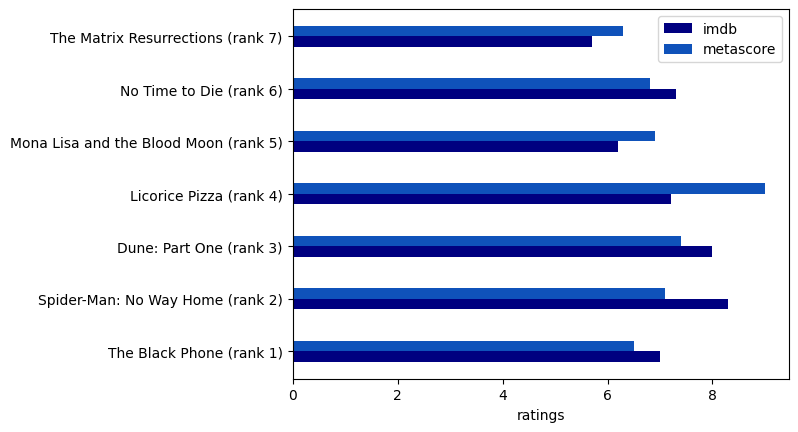

In [22]:
import matplotlib.pyplot as plt
import numpy as np
plt.clf()
fig, ax = plt.subplots()
width = 0.2 
x = np.arange(topby_rank['title'].size)

ax.barh(x, topby_rank['imdb'], width, color='#000080', label='imdb')
ax.barh(x + width, topby_rank['metascore'], width, color='#0F52BA', label='metascore')
ax.set_yticks(x + width - (width/2))
ax.set_yticklabels(topby_rank['rank_title'] )
ax.set_xlabel('ratings')
ax.legend() 


Next, let's plot 7 popularity based on imdb rating and metascore


Text(0.5, 0, 'ratings')

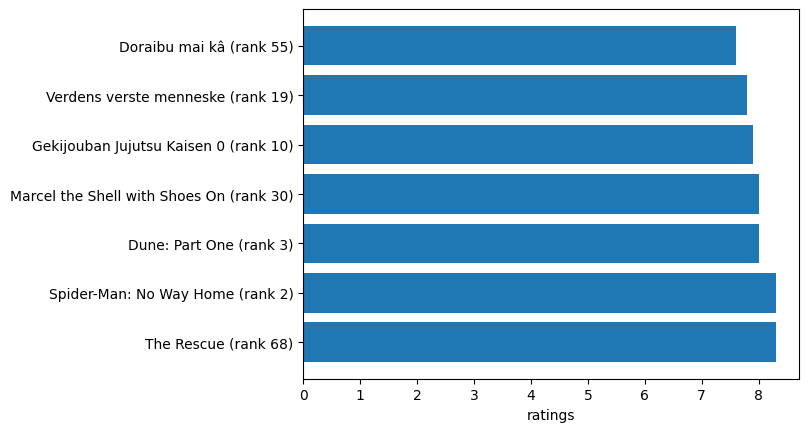

In [23]:
topby_imdb=movie.sort_values('imdb',ascending=False).head(7)
# topby_imdb.plot.barh(x='title',y='imdb')
plt.clf()
plt.barh(topby_imdb['rank_title'],topby_imdb['imdb'])
plt.xlabel('ratings')

Text(0.5, 0, 'ratings')

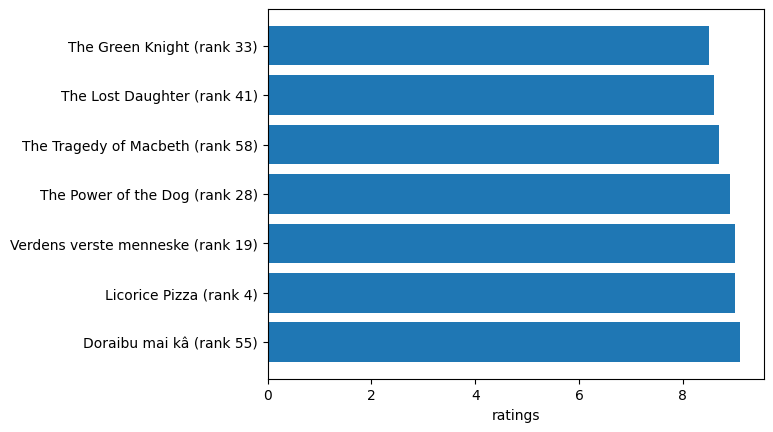

In [24]:
topby_ms=movie.sort_values('metascore',ascending=False).head(7)
# topby_ms.plot.barh(x='title',y='metascore')
plt.clf()
plt.barh(topby_ms['rank_title'],topby_ms['metascore'])
plt.xlabel('ratings')

Data above shows that popularity by imdb is not based on imdb rating or metascore. We will check imdb FAQ (source: [sort by MOVIEmeter](https://help.imdb.com/article/imdbpro/industry-research/starmeter-moviemeter-and-companymeter-faq/GSPB7HDNPKVT5VHC?ref_=helpsrall#)).

Generally, imdb counts how many pageview from each title and addition with undisclosed algorithm to neutralize user who 'rig' the system.

Then, let's find correlations between ranking and others:

Text(0.5, 0, 'imdb ratings')

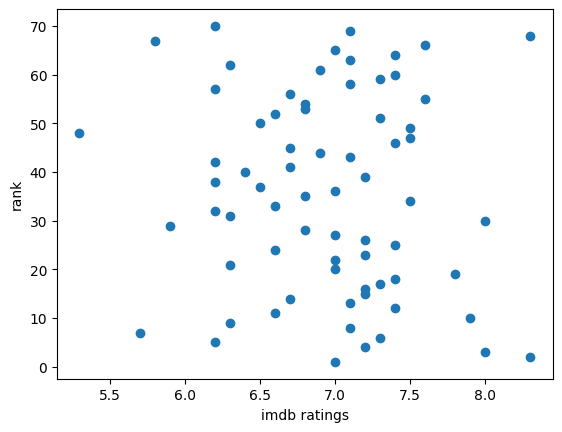

In [63]:
# movie.plot.scatter(x='rank',y='imdb')
plt.clf()
plt.scatter(movie['imdb'],movie['rank'])
plt.ylabel('rank')
plt.xlabel('imdb ratings')

Text(0.5, 0, 'metascore ratings')

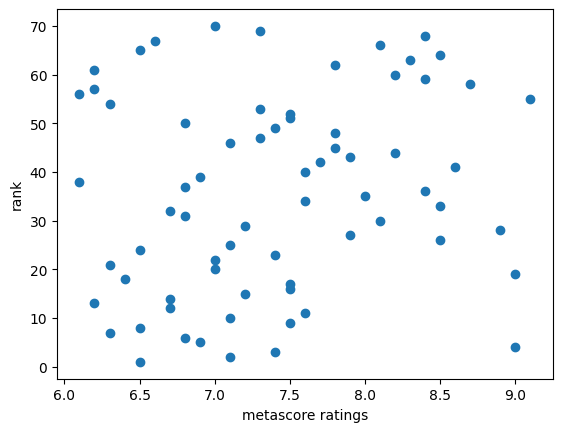

In [64]:
movie.plot.scatter(x='rank',y='metascore')
plt.clf()
plt.scatter(movie['metascore'],movie['rank'])
plt.ylabel('rank')
plt.xlabel('metascore ratings')

Both scatterplot, neither imdb rating or metascore have correlation with ranking.

For further analysis, we will utilize `votes`, `release_date` and take into account the imdb rating. Based on [imdb rating's FAQ](https://help.imdb.com/article/imdb/track-movies-tv/weighted-average-ratings/GWT2DSBYVT2F25SK?ref_=helpart_nav_8#), votes already used as 'weight' into imdb rating, so we won't use `votes`.

How about `release_date` ? let's make correlation with ranking:

C:\Users\62857\AppData\Local\Temp\ipykernel_25540\2920502036.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['2021-01','2021-03','2021-05','2021-07','2021-09','2021-11','2021-12-31'])


Text(0, 0.5, 'ranks')

<Figure size 640x480 with 0 Axes>

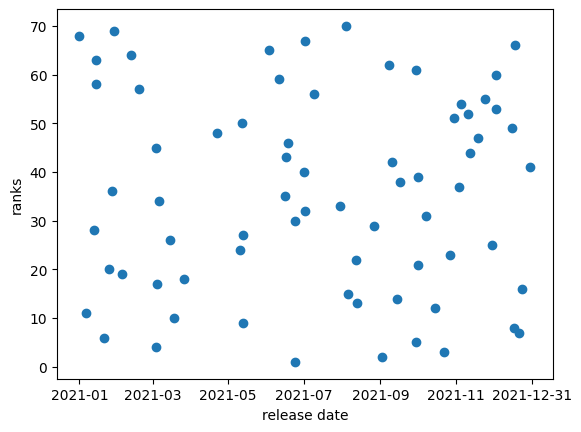

In [73]:
# movie.plot.scatter(x='rank',y='release_date')
plt.clf()
fig, ax = plt.subplots()
ax.scatter(movie['release_date'],movie['rank'])
ax.set_xticklabels(['2021-01','2021-03','2021-05','2021-07','2021-09','2021-11','2021-12'])
ax.set_xlabel('release date')
ax.set_ylabel('ranks')

Nor release date also doesn't have correlation with ranking.

We conclude that imdb rating, metascore and release date doesn't have any correlation with popularity.

***

For additional analysis, imdb and metascore rating will be compared using `hist()`

array([[<AxesSubplot:title={'center':'imdb'}>,
        <AxesSubplot:title={'center':'metascore'}>]], dtype=object)

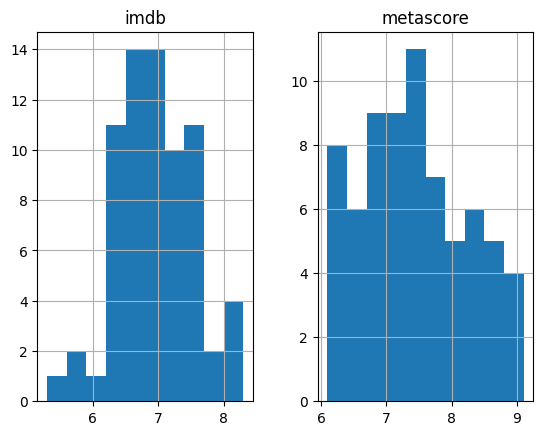

In [32]:
hist_imdb_ms = movie[['imdb','metascore']]
hist_imdb_ms.hist()

Based on both histogram, metascore resembles more as normal distribution. It has more bars around lowest and highest rating area.
In imdb's histogram, distribution tend to average area (x-axis between 6 and 8). 
<br><br>
metascore is review from leading critics which is reviewer more filtered than imdb. 
<br><br>
Conclusion, metascore rating is better suited to movie enthusiast (considering all aspect of movie).